In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, ITURadioMaterial, SceneObject

import matplotlib.pyplot as plt

import drjit.cuda as dr
import mitsuba as mi

import numpy as np

import sionnautils
from scipy.spatial.transform import Rotation as R

from UE_config import UE

import mitsuba as mi
import drjit as dr
from sionna.rt import AntennaPattern, PlanarArray, register_antenna_pattern
from sionnautils.custom_scene import list_scenes, get_scene



In [2]:
def is_inside_building_mitsuba(scene, point, direction=np.array([0, 0, 1]), max_hits=50):
    """
    Casts a ray and counts intersections to determine if point is inside a mesh.
    """
    ray_origin = mi.Point3f(point)
    ray_dir = mi.Vector3f(direction)
    ray = mi.Ray3f(o=ray_origin, d=ray_dir)

    scene_mi = scene._scene  # Internal Mitsuba scene from Sionna

    count = 0
    for _ in range(max_hits):
        si = scene_mi.ray_intersect(ray, active=dr.ones(mi.Bool, 1)[0])
        if not si.is_valid():
            break
        count += 1
        ray.o = si.p + 1e-4 * ray.d  # Offset origin to avoid repeated self-hit

    return (count % 2 == 1)

def ue_inside_building(scene, point, direction=np.array([0, 0, 1]), max_hits=50):
    
    check_rx1 = is_inside_building_mitsuba(scene, point + np.array([-0.037,0.09,0]))
    check_rx2 = is_inside_building_mitsuba(scene, point + np.array([0.037,-0.09,0]))
    check_rx3 = is_inside_building_mitsuba(scene, point + np.array([0.037,0.09,0]))
    check_rx4 = is_inside_building_mitsuba(scene, point + np.array([-0.037,-0.09,0]))
    
    return check_rx1 and check_rx2 and check_rx3 and check_rx4

In [3]:
from matplotlib.path import Path

def is_point_in_region(region_vertices_3d, point_3d):

    point_xy = point_3d[:2]
    polygon_xy = region_vertices_3d[:, :2]
    path = Path(polygon_xy)
    return path.contains_point(point_xy)


In [4]:
from sionnautils.custom_scene import list_scenes, get_scene
scenes = list_scenes()
print(scenes)

scene_path, map_data = get_scene('nyu_tandon')
for k, v in map_data.items():
    print(f'{k}: {v}')

scene = load_scene(scene_path,merge_shapes=True)

floor = scene.get('ground')
# print(f'Floor material: {floor.radio_material.name}')
floor.radio_material = ITURadioMaterial("itu_concrete",
                                "concrete",
                                thickness=0.01,
                                color=(0.5, 0.5, 0.5))

scene.remove("itu_wet_ground")

for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')
# scene.render(camera=my_cam, num_samples=512)

scene.radio_materials

['nyu_tandon']
bbox_lat: [40.69012764197041, 40.699120858029595]
bbox_long: [-73.99156687083165, -73.97970552916836]
address: 5 MetroTech Center, Brooklyn, NY 11201
descr: NYU Tandon campus


2025-06-10 16:17:43 WARN wrk8 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

no-name-1      itu_marble
ground         itu_concrete


{'itu_marble': ITURadioMaterial type=marble
                  eta_r=7.074
                  sigma=0.018
                  thickness=0.100
                  scattering_coefficient=0.000
                  xpd_coefficient=0.000,
 'itu_concrete': ITURadioMaterial type=concrete
                  eta_r=5.240
                  sigma=0.123
                  thickness=0.010
                  scattering_coefficient=0.000
                  xpd_coefficient=0.000}

In [5]:
test_point = np.array([48.935, -93.4887, 1.01218]) 
inside = is_inside_building_mitsuba(scene, test_point)
print(f"Point {test_point} inside building? {inside}")

region = np.array([[-125,35,1], [35,35,1],[35,-100,1],[-125,-100,1]])


inregion = is_point_in_region(region, test_point)
print(f"Point {test_point} inside region? {inregion}")

Point [ 48.935   -93.4887    1.01218] inside building? False
Point [ 48.935   -93.4887    1.01218] inside region? False


In [6]:
import gym
import numpy as np

rand_seed = 42

# Constants
v_max = 10.0
v_min = 0.0
dv_min, dv_max = -2, 2  # change in speed per seconds
dphi_min, dphi_max = -np.pi/6, np.pi/6  # change in angle per step
dt = 0.05  # time step in seconds

# Action space: [Δv, Δθ]
action_space = gym.spaces.Box(low=np.array([dv_min *dt, dphi_min *dt]),
                              high=np.array([dv_max *dt, dphi_max *dt]),
                              dtype=np.float64)
action_space.seed(rand_seed)
np.random.seed(rand_seed)


In [7]:

# Initial state
##### s1
# x, y, phi = 0, -50, np.pi 
# x, y, phi = -50, 8, np.pi / 2
# x, y, phi = 50, 30, 0 

##### s2
x, y, phi = -280, -100, 0

v = 0.0  # initial speed

# Store trajectory
trajectory = [(x, y, phi, v)]

routes = []
xs = []
ys = []
vs = []
angles = []

time = 1200
n_steps = time / dt

# # s1 region
# region = np.array([[-125,35,1], [50,35,1],[50,-100,1],[-125,-100,1]])
# tx_loc =[50,-115,10]
# tx_loc =[-50,45,10]

# s2 region
region = np.array([[-300,200,1], [-100,200,1],[-100,-150,1],[-300,-150,1]])
tx_loc =[-300,0,10]

step = 0
while step < n_steps:
    
    # if step % 100 == 0:
    #     print(step)
    
    # Sample action
    dv, dphi = action_space.sample()

    # Update speed and clip
    v = np.clip(v + dv, v_min, v_max)

    # Update heading
    phi += dphi

    # Update position
    temp_x = x + v * np.cos(phi) * dt
    temp_y = y+ v * np.sin(phi) * dt
    
    test_point = np.array([temp_x,temp_y,1]) 
    if ue_inside_building(scene, test_point) or (not is_point_in_region(region, test_point)):
        print(step)
        phi = phi + np.random.choice([-1, 1]) * np.pi / 6
        continue
    
    x = temp_x
    y = temp_y

    # # Store new state
    # if phi > np.pi:
    #     phi -= 2* np.pi
    # elif phi <= -np.pi:
    #     phi += 2* np.pi
    
    trajectory.append((x, y, phi, v))
    
    xs.append(x)
    ys.append(y)
    angles.append(phi)
    vs.append(v)
    
    
    
    routes.append([x,y,1])
    step += 1

# Print the trajectory
for i, (x, y, phi, v) in enumerate(trajectory):
    print(f"Step {i:2d}: x = {x:.3f}, y = {y:.3f}, phi = {phi:.3f}, v = {v:.3f}")


970
970
970
970
970
971
971
971
1682
1682
1682
1682
1960
1960
1960
1960
1960
1960
1960
1960
1960
1960
1960
1960
1960
1960
1975
1975
1976
2387
2708
2708
2708
2708
2708
2708
2708
2708
2708
2708
2708
2783
2783
2783
2783
2783
2783
2803
2804
2804
2804
2804
2804
2804
2804
2804
2804
2805
2805
2805
2805
2805
2805
2808
2809
2809
2809
2809
2809
2809
2809
2809
2810
2810
2810
2810
2810
2810
2811
2811
2811
2811
2811
2811
2811
2811
2811
2811
2811
2811
2811
2866
5382
5382
5383
5383
6555
6556
7051
7053
7053
7053
7053
7053
7743
7744
7745
7754
7754
7762
7762
7762
7762
7764
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8260
8607
8607
8611
9068
9068
9068
9068
9068
9281
9281
9281
9281
9281
9701
9701
9701
9701
9701
9701
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9770
9771
9771
9771
9771
9771
9772
10342
10342
10342
10342
10342
10342
10342
10342
10342
10342
10415
10415
10416
10867
10867
10868
10

In [8]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                position=tx_loc,
                 display_radius=2)
scene.remove("tx")
scene.add(tx)

# scene.preview()


In [9]:
scene.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="iso",
                              polarization="V")


for idx in range(step):
    # print(idx)
    rx = Receiver(name=f"rx-{idx}",
              position=np.array(routes[idx]),
              display_radius=1)
    scene.remove(f"rx-{idx}")
    scene.add(rx)
    
# for idx in range(len(region)):
#     # print(idx)
#     rx = Receiver(name=f"region-{idx}",
#               position=np.array(region[idx]),
#               display_radius=2)
#     scene.add(rx)

In [10]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [11]:
measure_index = range(int(n_steps))
measure_index

range(0, 24000)

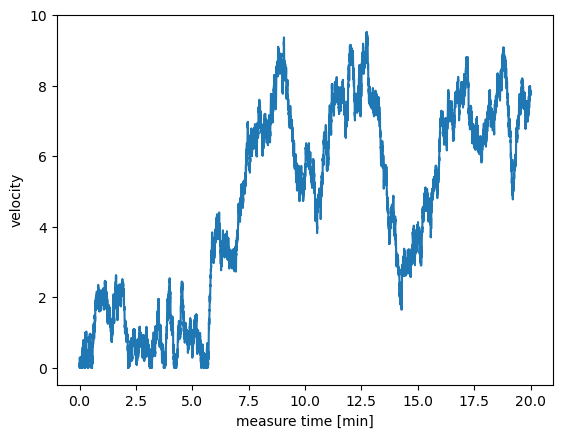

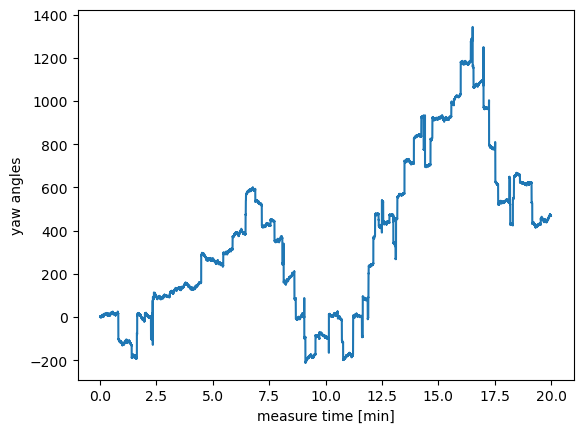

In [12]:


plt.figure()

plt.plot(np.array(measure_index) * dt / 60, np.array(vs), label=f"yaw angle")

# plt.legend(loc = "lower left")
plt.xlabel("measure time [min]")
plt.ylabel("velocity")
# plt.ylim(-75,-60)
plt.show()

plt.figure()

plt.plot(np.array(measure_index) * dt / 60, np.array(angles) / (2*np.pi) * 360, label=f"yaw angle")

# plt.legend(loc = "lower left")
plt.xlabel("measure time [min]")
plt.ylabel("yaw angles")
# plt.ylim(-75,-60)
plt.show()

In [13]:
import json

with open('ue2_s2_1_10mps_routes_seed42_1200s.json', 'w') as f:
    json.dump(routes, f)

In [14]:
import json
with open('ue2_s2_1_10mps_routes_seed42_1200s.json', 'r') as f:
    loaded_routes = json.load(f)

In [15]:
len(loaded_routes)

24000

In [16]:
loaded_routes

[[-279.9972604535438, -100.00000876744815, 1],
 [-279.99093507481746, -99.99996364238959, 1],
 [-279.9886689251321, -99.99989101604943, 1],
 [-279.98379560608424, -99.99966172472415, 1],
 [-279.9826369035445, -99.99961022373706, 1],
 [-279.9826369035445, -99.99961022373706, 1],
 [-279.9812032843258, -99.99949000221973, 1],
 [-279.980332591002, -99.99942949530335, 1],
 [-279.9789154862172, -99.99936349163877, 1],
 [-279.9742272350204, -99.99911272817592, 1],
 [-279.9669590411101, -99.99877946838183, 1],
 [-279.95500263961833, -99.99798435265201, 1],
 [-279.9402547560899, -99.99724021043066, 1],
 [-279.9258259793261, -99.9968573478831, 1],
 [-279.9148563857924, -99.99646103233988, 1],
 [-279.9014566490713, -99.99564812580812, 1],
 [-279.88979093241176, -99.99501980007126, 1],
 [-279.8784207693446, -99.9945926537323, 1],
 [-279.8707484220941, -99.9943141975596, 1],
 [-279.8658069750976, -99.9940908454424, 1],
 [-279.8614974183765, -99.99382076621995, 1],
 [-279.8551855523063, -99.99348742